# Importing libraries and Data cleaning

In [1]:
!pip install pmdarima

In [2]:
!pip install iplot

In [3]:
!pip install cufflinks

In [4]:
# linear algebra
import numpy as np 
import math

# data processing
import pandas as pd

# data visualization(for EDA)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set(color_codes=True)
import plotly.express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



#For lstm model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#for Arima model
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [5]:
df=pd.read_csv('Precipitation2.csv')
df.head()

,year,month,rainfall
0,1940,January,82.9
1,1940,February,64.9
2,1940,March,111.3
3,1940,April,56.5
4,1940,May,15.8


In [6]:
#creating index column
df['date']=pd.to_datetime(df['year'].astype(str)  + df['month'], format='%Y%B').dt.to_period('m')
df = df.set_index('date')
df = df.rename(columns = {'rainfall':'rainfall',' year':'year'})
df.head()

,year,month,rainfall
date,,,
1940-01,1940,January,82.9
1940-02,1940,February,64.9
1940-03,1940,March,111.3
1940-04,1940,April,56.5
1940-05,1940,May,15.8


# Exploratory Data Analysis

In [7]:
ax=df.groupby([df.year]).mean()['rainfall']
fig = px.line(ax, x=ax.index, y='rainfall', title='Annual rainfall in Mbombela  from 1940 to 2019')
fig.update_traces(mode='lines+markers',line=dict(color='Orange'))
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

In [8]:
ax=df.groupby('year').mean()['rainfall'].rolling(10).mean()
fig = px.line(ax, x=ax.index, y='rainfall', title='Rolling average of 10 years of Rainfall')
fig.update_traces(mode='lines+markers',line=dict(color='Black'))
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

In [9]:
ax=df.groupby([df.month]).mean()['rainfall']
fig = px.bar(ax,y='rainfall',title='Monthly Rainfall in Mbombela',category_orders={"month": ["January", "February", "March", "April", "May", "June",
      "July", "August", "September", "October", "November", "December"]},color_discrete_sequence=px.colors.qualitative.D3)
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

In [10]:
ax=df.groupby([df.index.year]).agg({'rainfall':sum})
print('The largest amount of rain was recorded in the following years')
ax['rainfall'].nlargest(5)

The largest amount of rain was recorded in the following years


date
2000    1360.7
1996    1205.0
2006    1125.2
1955    1118.3
1942    1108.6
Name: rainfall, dtype: float64

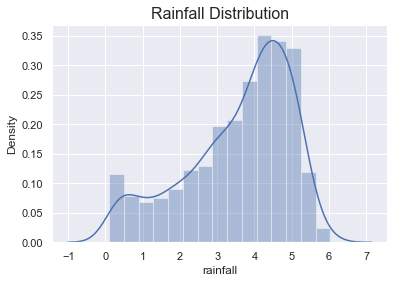

In [11]:
g1 = sns.distplot(np.log(df['rainfall'] + 1))
g1.set_title("Rainfall Distribution", fontsize=16);

# LSTM Model

In [12]:
#Data preprcessing
dataset = df.drop(columns = ['month','year'])
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Converting an array of values into a dataset matrix. The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period and in our case look back is 1.

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
# split into train and test sets
training_size=int(len(dataset)*0.90)
test_size=len(dataset)-training_size
train, test =dataset[0:training_size,:],dataset[training_size:len(dataset),:1]

#reshape into X=t and Y=t+1
look_back =12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: (samples, time steps, features) but Currently, our data is in the form: (samples, features)

In [15]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network.

In [16]:
#create and fit the LSTM network
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,look_back)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=600, batch_size=200, validation_data=(testX, testY), shuffle=False)

Epoch 1/600
4/4 [==============================] - 5s 338ms/step - loss: 0.0517 - val_loss: 0.0358
Epoch 2/600
4/4 [==============================] - 0s 8ms/step - loss: 0.0471 - val_loss: 0.0320
Epoch 3/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0424 - val_loss: 0.0282
Epoch 4/600
4/4 [==============================] - 0s 10ms/step - loss: 0.0378 - val_loss: 0.0246
Epoch 5/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0333 - val_loss: 0.0215
Epoch 6/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0292 - val_loss: 0.0194
Epoch 7/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0262 - val_loss: 0.0188
Epoch 8/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0249 - val_loss: 0.0195
Epoch 9/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0248 - val_loss: 0.0199
Epoch 10/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0244 - val_loss: 0.0189
Epoch 11/600
4/4 [========

# Check for overfitting and underfitting

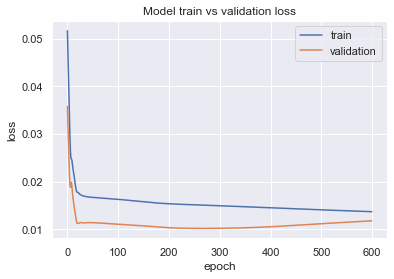

In [17]:
# plot train and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

The model is fit, now we can estimate the performance of the model on the test datasets.

# Predict results and Checking for accuracy scores

In [18]:
testPredict = model.predict(testX)
# invert predictions
test_Predict = scaler.inverse_transform(testPredict)
test_Y = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(test_Y[0], test_Predict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Test Score: 45.224 RMSE


In [19]:
testScore = mean_squared_error(test_Y[0], test_Predict[:,0])
print('Test Score: %.3f MSE' % (testScore))

Test Score: 2045.188 MSE


In [20]:
testScore = mean_absolute_error(test_Y[0], test_Predict[:,0])
print('Test Score: %.3f MAE' % (testScore))

Test Score: 30.192 MAE


In [21]:
testScore = mean_absolute_percentage_error(test_Y[0], test_Predict[:,0])
print('Test Score: %.3f MAPE' % (testScore))

Test Score: 4.129 MAPE


In [22]:
data = df.drop(columns = ['month','year'])
testindex=data[-(testY.size):]
future_forecast = pd.DataFrame(test_Predict[:,0],index =testindex.index,columns=['Prediction'])
pd.concat([testindex,future_forecast],axis=1).iplot()

In [24]:
#Training the data using cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

RMSE = []
MSE =[]
MAE =[]
MAPE =[]

nn = 10

model=Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(1,look_back)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

  

tscv = TimeSeriesSplit(max_train_size=None, n_splits=nn)
for train_index, test_index in tscv.split(trainX):
    tX,testX=trainX[train_index], trainX[test_index]
    tY,testY = trainY[train_index], trainY[test_index]
    history = model.fit(tX, tY, epochs=300, batch_size=120, validation_data=(testX, testY), shuffle=False)
    
    testPredict = model.predict(testX)
# invert predictions
    test_Predict = scaler.inverse_transform(testPredict)
    test_Y = scaler.inverse_transform([testY])
# calculate root mean squared error
    testScore = math.sqrt(mean_squared_error(test_Y[0], test_Predict[:,0]))
    print('Test Score: %.3f RMSE' % (testScore))
    
    testScore = mean_squared_error(test_Y[0], test_Predict[:,0])
    print('Test Score: %.3f MSE' % (testScore))
    
    testScore = mean_absolute_error(test_Y[0], test_Predict[:,0])
    print('Test Score: %.3f MAE' % (testScore))
    
    testScore = mean_absolute_percentage_error(test_Y[0], test_Predict[:,0])
    print('Test Score: %.3f MAPE' % (testScore))
    

Epoch 1/300
1/1 [==============================] - 7s 7s/step - loss: 0.0619 - val_loss: 0.0367
Epoch 2/300
1/1 [==============================] - 0s 27ms/step - loss: 0.0606 - val_loss: 0.0358
Epoch 3/300
1/1 [==============================] - 0s 18ms/step - loss: 0.0594 - val_loss: 0.0349
Epoch 4/300
1/1 [==============================] - 0s 20ms/step - loss: 0.0581 - val_loss: 0.0339
Epoch 5/300
1/1 [==============================] - 0s 20ms/step - loss: 0.0568 - val_loss: 0.0331
Epoch 6/300
1/1 [==============================] - 0s 26ms/step - loss: 0.0556 - val_loss: 0.0322
Epoch 7/300
1/1 [==============================] - 0s 24ms/step - loss: 0.0543 - val_loss: 0.0313
Epoch 8/300
1/1 [==============================] - 0s 24ms/step - loss: 0.0530 - val_loss: 0.0304
Epoch 9/300
1/1 [==============================] - 0s 20ms/step - loss: 0.0517 - val_loss: 0.0295
Epoch 10/300
1/1 [==============================] - 0s 24ms/step - loss: 0.0504 - val_loss: 0.0286
Epoch 11/300
1/1 [===

In [25]:
data = df.drop(columns = ['month','year'])
testindex=data[-(testY.size):]
future_forecast = pd.DataFrame(test_Predict[:,0],index =testindex.index,columns=['Prediction'])
pd.concat([testindex,future_forecast],axis=1).iplot()

# ARIMA Model

In [26]:
test_result=adfuller(df['rainfall'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['rainfall'])

ADF Test Statistic : -7.200906045063223
p-value : 2.3669408812724056e-10
#Lags Used : 11
Number of Observations : 793
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [27]:
# split into train and test sets
df = df.drop(columns = ['month','year'])
training_size=int(len(df)*0.90)
test_size=len(df)-training_size
train,valid=df.iloc[0:training_size,:],df.iloc[training_size:len(df),:1]
training,validation=train['rainfall'], valid['rainfall']

In [28]:
model = auto_arima(training, start_p=0, start_q=0,max_p=3, max_q=3, m=12,start_P=0,start_Q=0,max_P=1,max_Q=1, seasonal=True,d=0, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8252.213, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8095.230, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8250.221, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8204.501, Time=0.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=8175.575, Time=0.64 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=8091.870, Time=0.83 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=8200.643, Time=0.11 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=8080.242, Time=1.08 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=8196.404, Time=0.16 sec
 ARIMA(3,0,0)(1,1,1)[12] intercept   : AIC=i

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

# Predict results and Checking for accuracy scores

In [29]:
future_forecast = model.predict(len(valid))
future_forecast = pd.DataFrame(future_forecast,index =valid.index,columns=['Prediction'])
#iplot.title("Machine Learned the Pattern Predicting Future Values ")
pd.concat([valid,future_forecast],axis=1).iplot()

In [30]:
testScore = math.sqrt(mean_squared_error(valid,future_forecast))
print('Test Score: %.3f RMSE' % (testScore))

Test Score: 58.552 RMSE


In [34]:
testScore = mean_squared_error(valid,future_forecast)
print('Test Score: %.3f MAE' % (testScore))

Test Score: 3428.321 MAE


In [35]:
testScore = mean_absolute_error(valid,future_forecast)
print('Test Score: %.3f MAE' % (testScore))

Test Score: 42.434 MAE


In [36]:
testScore = mean_absolute_percentage_error(valid,future_forecast)
print('Test Score: %.3f MAPE' % (testScore))

Test Score: 5.631 MAPE
